In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/BDM25/csv_data/

appearances.csv   delta_data	    persistent_data	    transfers.csv
club_games.csv	  game_events.csv   persistent_data_Jintao
clubs.csv	  game_lineups.csv  players.csv
competitions.csv  games.csv	    player_valuations.csv


**Exploitation Zone**

In [ ]:
!pip install pyspark matplotlib duckdb

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, avg, col
import os

# Initialize Spark session
spark = SparkSession.builder.appName("ExploitationZoneFootball").getOrCreate()

# Define the directories for input (Trusted Zone) and output (Exploitation Zone)
trusted_dir = "/content/drive/MyDrive/Colab Notebooks/BDM25/trusted/"
exploitation_dir = "/content/drive/MyDrive/Colab Notebooks/BDM25/exploitation/"

# Load cleaned and validated data from the Trusted Zone (stored as Parquet files)
appearances = spark.read.parquet(f"{trusted_dir}appearances.parquet")
players = spark.read.parquet(f"{trusted_dir}players.parquet")
games = spark.read.parquet(f"{trusted_dir}games.parquet")
club_games = spark.read.parquet(f"{trusted_dir}club_games.parquet")
clubs = spark.read.parquet(f"{trusted_dir}clubs.parquet")

# ➤ Derive Player Performance Table:
# For each player, calculate total appearances, goals, assists, and average minutes played.
# Join with player names from the players table for readability.
player_perf = appearances.groupBy("player_id").agg(
    count("*").alias("total_appearances"),
    sum("goals").alias("total_goals"),
    sum("assists").alias("total_assists"),
    avg("minutes_played").alias("avg_minutes_played")
).join(players.select("player_id", "name"), on="player_id", how="left")

# ➤ Derive Club Win Rate Table:
# Convert boolean 'is_win' column to integer and compute total games and number of wins.
# Calculate win rate = wins / total games.
# Join with club names for easier interpretation.
club_perf = club_games.withColumn("win", col("is_win").cast("int")) \
    .groupBy("club_id").agg(
        count("*").alias("total_games"),
        sum("win").alias("wins")
    ).withColumn("win_rate", col("wins") / col("total_games")) \
    .join(clubs.select("club_id", "name"), on="club_id", how="left")

# ➤ Derive Player Contribution Rate Table:
# For each player, calculate contribution rate = (goals + assists) / total games.
# Join with player names for visualization.
player_contrib = appearances.groupBy("player_id").agg(
    count("*").alias("games"),
    sum("goals").alias("goals"),
    sum("assists").alias("assists")
).withColumn("contribution_rate", (col("goals") + col("assists")) / col("games")) \
 .join(players.select("player_id", "name"), on="player_id", how="left")

# Save all derived KPI tables to the Exploitation Zone in Parquet format
# This enables further analytics or visualization in the next stage
player_perf.write.mode("overwrite").parquet(f"{exploitation_dir}player_performance.parquet")
club_perf.write.mode("overwrite").parquet(f"{exploitation_dir}club_performance.parquet")
player_contrib.write.mode("overwrite").parquet(f"{exploitation_dir}player_contribution.parquet")


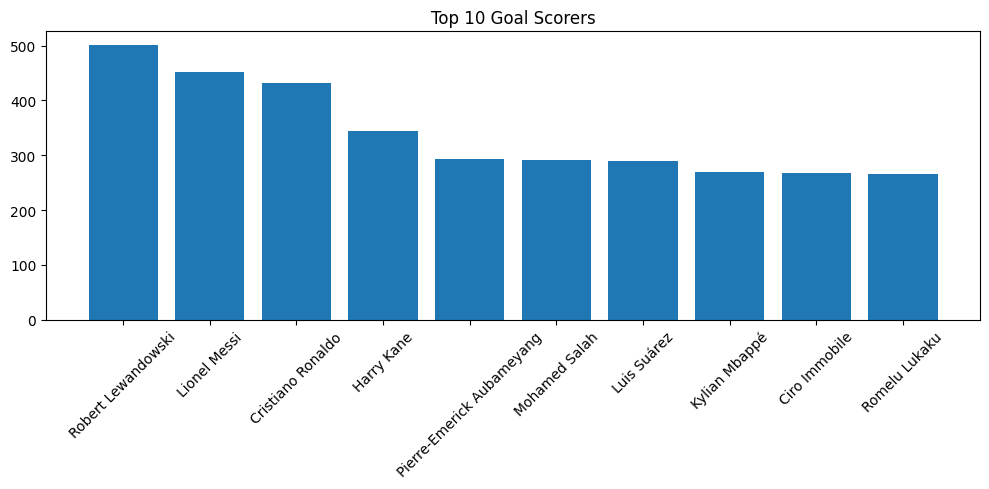

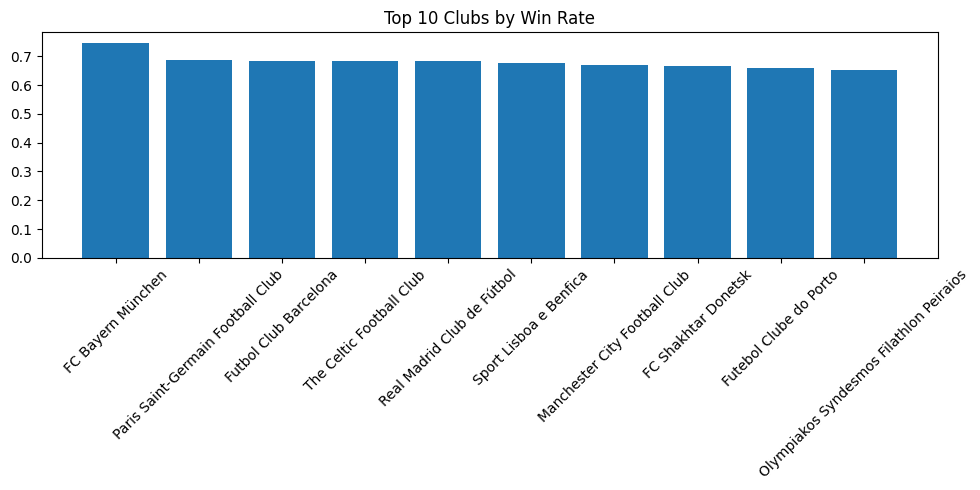

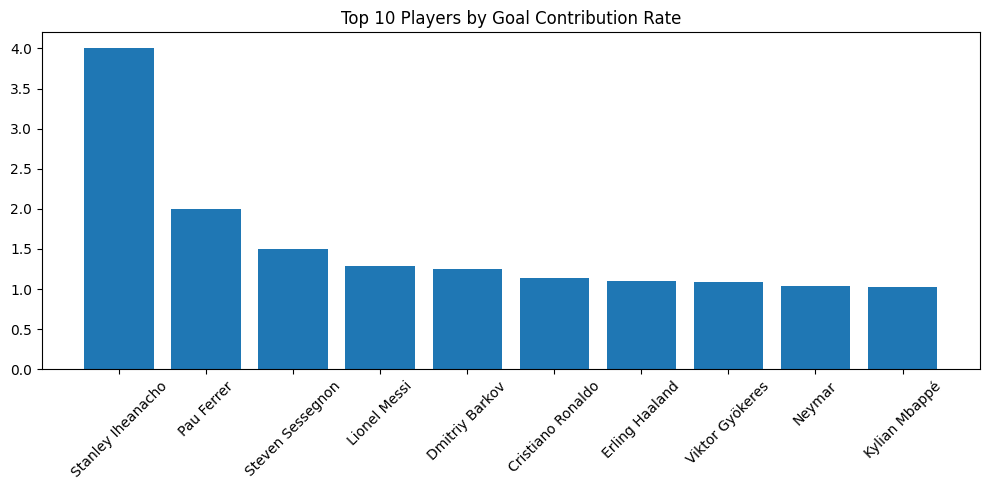

In [ ]:
import matplotlib.pyplot as plt

# Load the derived KPI datasets from the Exploitation Zone and convert them to Pandas DataFrames
df_perf = spark.read.parquet(f"{exploitation_dir}player_performance.parquet").toPandas()
df_club = spark.read.parquet(f"{exploitation_dir}club_performance.parquet").toPandas()
df_contrib = spark.read.parquet(f"{exploitation_dir}player_contribution.parquet").toPandas()

# ➤ Visualization 1: Top 10 Goal Scorers
# Filter out records with missing player names, sort by total goals, and take the top 10
top_scorers = df_perf.dropna(subset=["name"]).sort_values("total_goals", ascending=False).head(10)

# Plot a bar chart showing top scorers and their goal counts
plt.figure(figsize=(10, 5))
plt.bar(top_scorers["name"], top_scorers["total_goals"])
plt.xticks(rotation=45)
plt.title("Top 10 Goal Scorers")
plt.tight_layout()
plt.show()

# ➤ Visualization 2: Top 10 Clubs by Win Rate
# Remove rows with missing club names, sort by win rate, and take the top 10
top_clubs = df_club.dropna(subset=["name"]).sort_values("win_rate", ascending=False).head(10)

# Plot a bar chart showing clubs and their win rates
plt.figure(figsize=(10, 5))
plt.bar(top_clubs["name"], top_clubs["win_rate"])
plt.xticks(rotation=45)
plt.title("Top 10 Clubs by Win Rate")
plt.tight_layout()
plt.show()

# ➤ Visualization 3: Top 10 Players by Goal Contribution Rate
# Filter out players with missing names, sort by contribution rate, and take the top 10
top_contrib = df_contrib.dropna(subset=["name"]).sort_values("contribution_rate", ascending=False).head(10)

# Plot a bar chart showing players and their contribution rates (goals + assists per game)
plt.figure(figsize=(10, 5))
plt.bar(top_contrib["name"], top_contrib["contribution_rate"])
plt.xticks(rotation=45)
plt.title("Top 10 Players by Goal Contribution Rate")
plt.tight_layout()
plt.show()


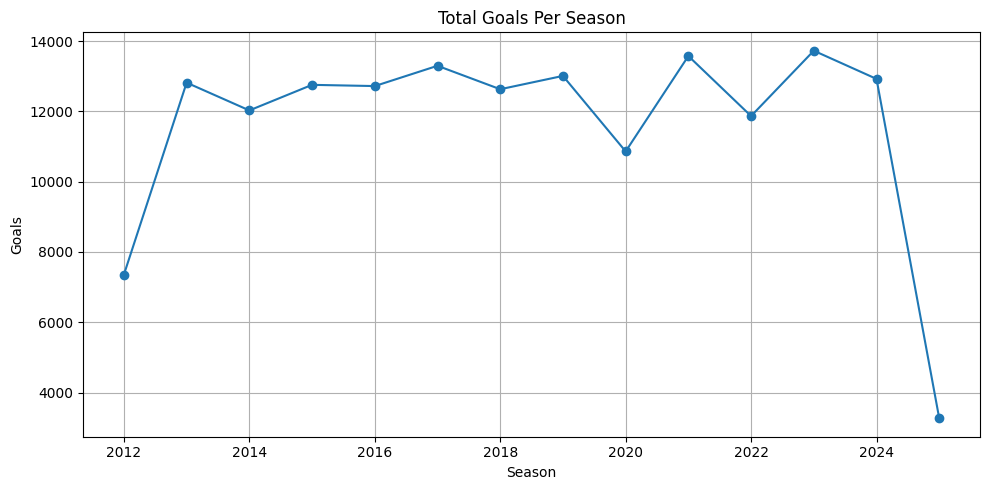

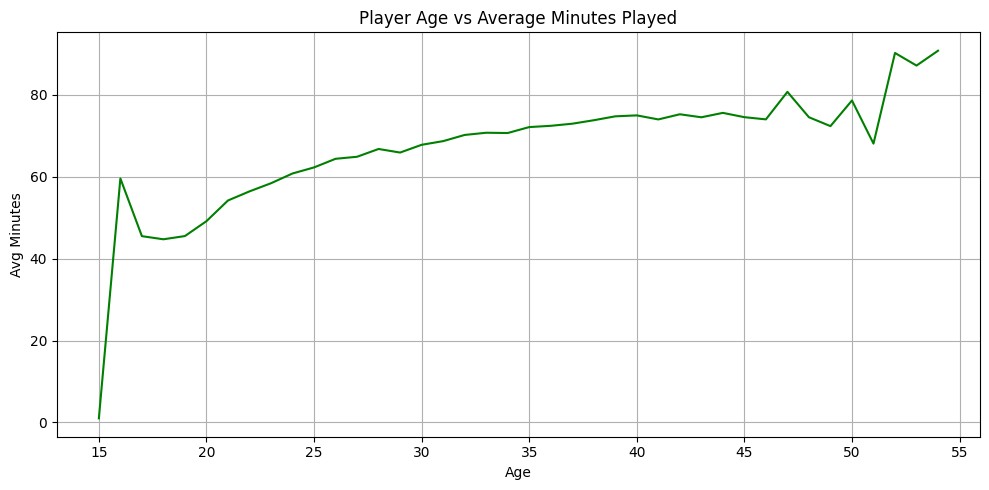

In [ ]:
from pyspark.sql.functions import year, to_date, when
import matplotlib.pyplot as plt

# ➤ Visualization 1: Total Goals Per Season

# Load the appearances data from the Trusted Zone
appearances_kpi = spark.read.parquet(f"{trusted_dir}appearances.parquet")

# Extract the season year from the match date and group by year to count total goals
goals_per_season = appearances_kpi.withColumn("season_year", year(to_date("date"))) \
    .groupBy("season_year").agg(sum("goals").alias("total_goals")) \
    .orderBy("season_year")

# Convert to Pandas DataFrame and drop any rows with nulls
df_goals_season = goals_per_season.toPandas().dropna()

# Plot a line chart of total goals scored per season
plt.figure(figsize=(10, 5))
plt.plot(df_goals_season["season_year"], df_goals_season["total_goals"], marker="o")
plt.title("Total Goals Per Season")
plt.xlabel("Season")
plt.ylabel("Goals")
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ Visualization 2: Player Age vs Average Minutes Played

from pyspark.sql.functions import datediff, current_date

# Load the players data and calculate player age in years
players_kpi = spark.read.parquet(f"{trusted_dir}players.parquet")
players_age = players_kpi.withColumn("age", (datediff(current_date(), to_date("date_of_birth")) / 365).cast("int"))

# Join player age with appearances data
app_join = appearances_kpi.join(players_age.select("player_id", "age"), on="player_id", how="left")

# Group by age and compute average minutes played
age_playtime = app_join.groupBy("age").agg(avg("minutes_played").alias("avg_minutes")).orderBy("age")

# Convert to Pandas DataFrame and drop any rows with nulls
df_age_playtime = age_playtime.toPandas().dropna()

# Plot a line chart showing how playing time varies with age
plt.figure(figsize=(10, 5))
plt.plot(df_age_playtime["age"], df_age_playtime["avg_minutes"], color="green")
plt.title("Player Age vs Average Minutes Played")
plt.xlabel("Age")
plt.ylabel("Avg Minutes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import year, to_date, col, avg, count, sum, when

# ➤ Load necessary data from the Trusted Zone
clubs = spark.read.parquet(f"{trusted_dir}clubs.parquet")
games = spark.read.parquet(f"{trusted_dir}games.parquet")
club_games = spark.read.parquet(f"{trusted_dir}club_games.parquet")

# ➤ Filter for Bundesliga clubs only (domestic_competition_id == "L1")
bundesliga_clubs = clubs.filter(col("domestic_competition_id") == "L1") \
    .select("club_id", "name", "average_age", "total_market_value")

# ➤ Filter Bundesliga games and extract season year and total goals per match
bundesliga_games = games.filter(col("competition_id") == "L1") \
    .withColumn("season", year(to_date("date"))) \
    .withColumn("total_goals", col("home_club_goals") + col("away_club_goals"))

# ➤ Group by season and calculate total goals
goals_per_season = bundesliga_games.groupBy("season") \
    .agg(sum("total_goals").alias("total_goals")) \
    .orderBy("season")

# ➤ Join Bundesliga club info with club match results
bundesliga_cg = club_games.join(bundesliga_clubs.select("club_id", "average_age"),
                                on="club_id", how="inner")

# ➤ Convert is_win to integer (1 if win, 0 otherwise)
bundesliga_cg = bundesliga_cg.withColumn("win", col("is_win").cast("int"))

# ➤ Group by club and compute average age, total games, wins, and win rate
age_vs_win = bundesliga_cg.groupBy("club_id").agg(
    avg("average_age").alias("avg_age"),
    count("*").alias("games"),
    sum("win").alias("wins")
).withColumn("win_rate", col("wins") / col("games"))

# ➤ Add club names for clarity
age_vs_win = age_vs_win.join(clubs.select("club_id", "name"), on="club_id", how="left")


# ➤ Extract ranking data from home and away teams in Bundesliga matches
ranking_data = games.filter(col("competition_id") == "L1") \
    .select("home_club_id", "away_club_id", "home_club_position", "away_club_position") \
    .withColumnRenamed("home_club_id", "club_id1") \
    .withColumnRenamed("home_club_position", "position1") \
    .withColumnRenamed("away_club_id", "club_id2") \
    .withColumnRenamed("away_club_position", "position2")

# ➤ Reshape the data into long format: one club per row
home_rank = ranking_data.select(col("club_id1").alias("club_id"),
                                col("position1").alias("position"))
away_rank = ranking_data.select(col("club_id2").alias("club_id"),
                                col("position2").alias("position"))
ranking_long = home_rank.union(away_rank).dropna()

# ➤ Compute each club’s average league position
avg_rank = ranking_long.groupBy("club_id") \
    .agg(avg("position").alias("avg_position"))

# ➤ Join with club metadata to retrieve market value and name
value_vs_rank = avg_rank.join(bundesliga_clubs.select("club_id", "name", "total_market_value"),
                              on="club_id", how="left")



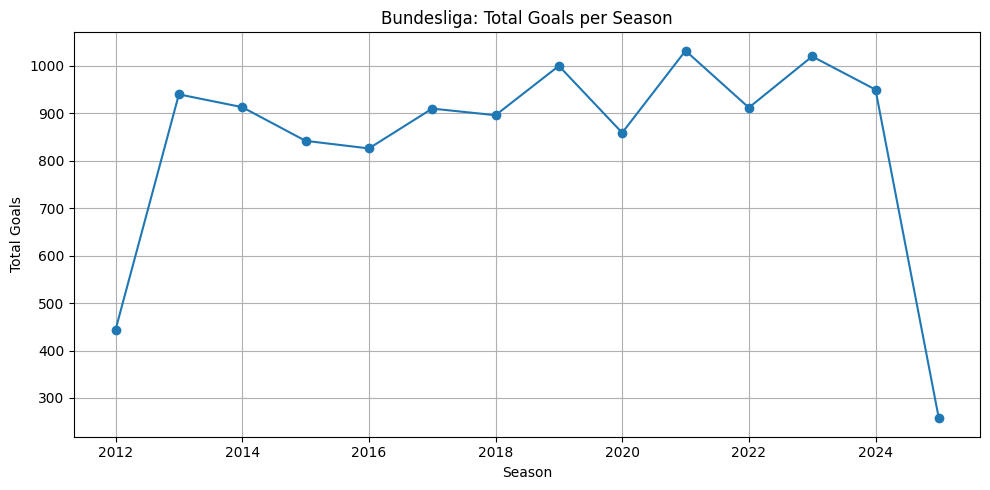

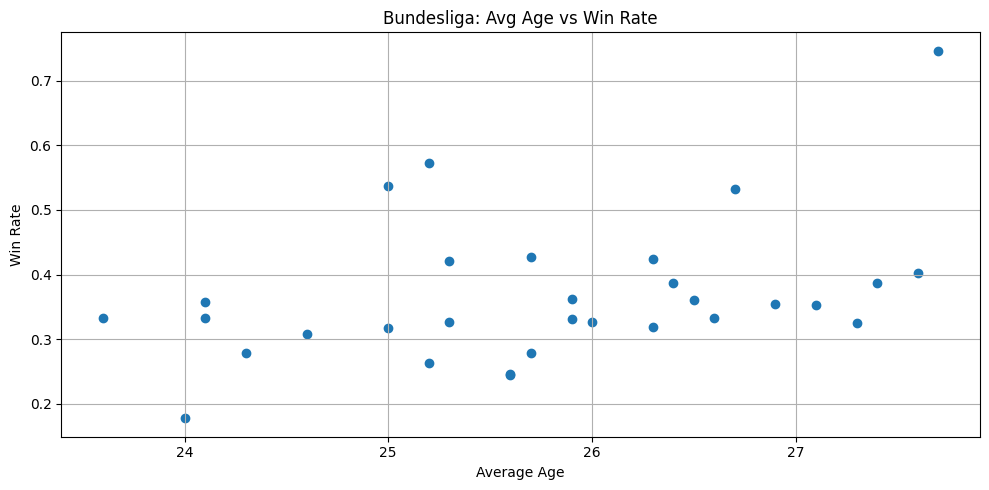

In [ ]:
import matplotlib.pyplot as plt

# ➤ KPI 1: Bundesliga Total Goals per Season
# Convert Spark DataFrame to Pandas for plotting
df_goals = goals_per_season.toPandas()

# ➤ Plot total goals per season using a line chart
plt.figure(figsize=(10, 5))
plt.plot(df_goals["season"], df_goals["total_goals"], marker="o")
plt.title("Bundesliga: Total Goals per Season")
plt.xlabel("Season")
plt.ylabel("Total Goals")
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ KPI 2: Average Age vs Win Rate
# Convert Spark DataFrame to Pandas and drop missing values
df_age_win = age_vs_win.toPandas().dropna()

# ➤ Scatter plot to explore the correlation between average age and win rate
plt.figure(figsize=(10, 5))
plt.scatter(df_age_win["avg_age"], df_age_win["win_rate"])
plt.title("Bundesliga: Average Age vs Win Rate")
plt.xlabel("Average Age")
plt.ylabel("Win Rate")
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
from pyspark.sql.functions import year, when, count, sum, avg, col, to_date

# Load trusted zone data
games = spark.read.parquet(f"{trusted_dir}games.parquet")
club_games = spark.read.parquet(f"{trusted_dir}club_games.parquet")
clubs = spark.read.parquet(f"{trusted_dir}clubs.parquet")
appearances = spark.read.parquet(f"{trusted_dir}appearances.parquet")
players = spark.read.parquet(f"{trusted_dir}players.parquet")

# 1️⃣ Bayern Munich KPI Analysis

# ➤ Get Bayern Munich's club ID
bayern_id = clubs.filter(col("name").like("%Bayern%")) \
    .select("club_id").limit(1).collect()[0][0]

# ➤ Extract all games played by Bayern Munich
bayern_games = club_games.filter(col("club_id") == bayern_id) \
    .join(games.select("game_id", "date"), on="game_id", how="left") \
    .withColumn("season", year(to_date("date")))

# ➤ KPI 1: Win rate per season
win_rate_season = bayern_games.withColumn("win", col("is_win").cast("int")) \
    .groupBy("season").agg(
        count("*").alias("games"),
        sum("win").alias("wins")
    ).withColumn("win_rate", col("wins") / col("games")) \
    .orderBy("season")

# ➤ KPI 2: Home vs Away win rate
home_away_perf = bayern_games.withColumn("win", col("is_win").cast("int")) \
    .groupBy("hosting").agg(
        count("*").alias("games"),
        sum("win").alias("wins")
    ).withColumn("win_rate", col("wins") / col("games"))

# ➤ KPI 3: Average goals per game (league level)
games_with_goals = games.filter((col("home_club_id") == bayern_id) | (col("away_club_id") == bayern_id)) \
    .withColumn("season", year(to_date("date"))) \
    .withColumn("goals_scored", when(
        col("home_club_id") == bayern_id, col("home_club_goals")
    ).otherwise(col("away_club_goals")))

goals_per_game = games_with_goals.groupBy("season").agg(
    avg("goals_scored").alias("avg_goals_per_game")
).orderBy("season")

# 2️⃣ Robert Lewandowski KPI Analysis

# ➤ Get Lewandowski's player ID
lewa_id = players.filter(col("name").like("%Lewandowski%")) \
    .select("player_id").limit(1).collect()[0][0]

# ➤ Extract Lewandowski's appearance records with season info
lewa_stats = appearances.filter(col("player_id") == lewa_id) \
    .withColumn("season", year(to_date("date")))

# ➤ KPI 1: Goals per season
goals_by_season = lewa_stats.groupBy("season").agg(
    sum("goals").alias("total_goals"),
    count("*").alias("appearances")
).orderBy("season")

# ➤ KPI 2: Average goals per game
goals_by_season = goals_by_season.withColumn(
    "avg_goals_per_game", col("total_goals") / col("appearances")
)

# ➤ KPI 3: Assist-to-goal ratio per season
assist_ratio = lewa_stats.groupBy("season").agg(
    sum("assists").alias("total_assists"),
    sum("goals").alias("total_goals")
).withColumn("assist_goal_ratio", col("total_assists") / col("total_goals")) \
 .orderBy("season")


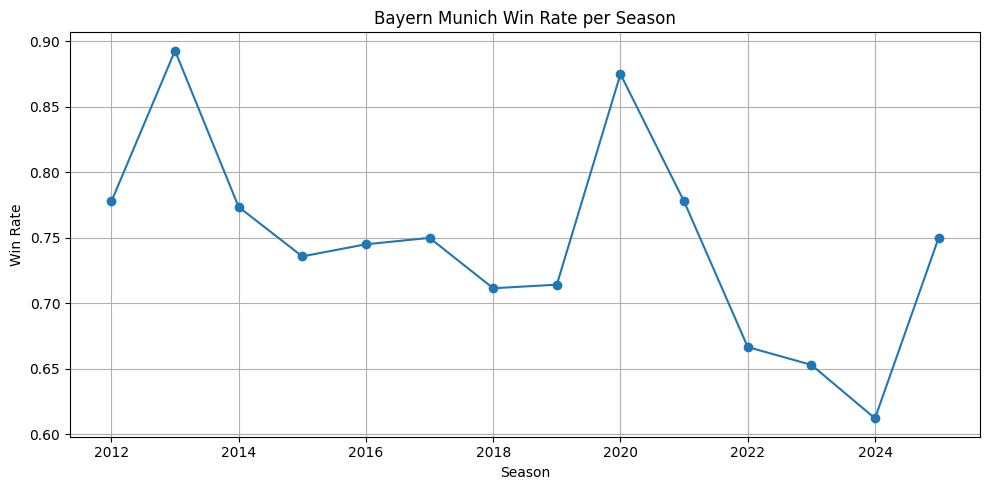

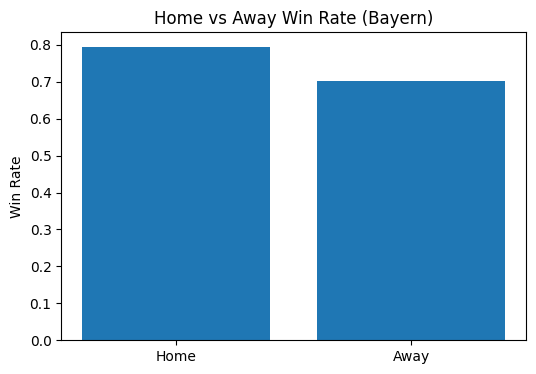

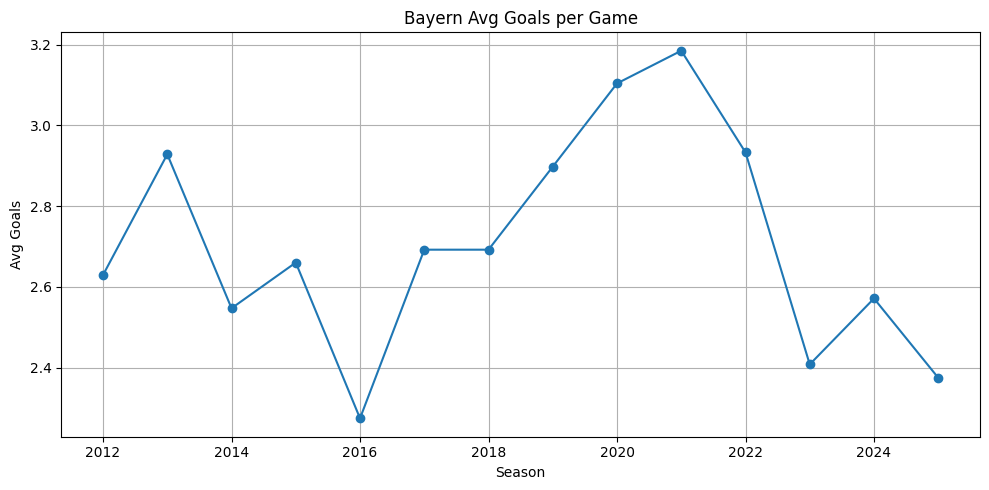

In [ ]:
import matplotlib.pyplot as plt

# Reusable line plot function for seasonal trends
def plot_line(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(df[x], df[y], marker="o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ⚽ Bayern Munich: Win Rate per Season
# Displays how Bayern's seasonal win rate has evolved
plot_line(
    win_rate_season.toPandas(),
    "season",
    "win_rate",
    "Bayern Munich Win Rate per Season",
    "Season",
    "Win Rate"
)

# ⚽ Bayern Munich: Home vs Away Win Rate
# Bar chart comparing win rate at home vs away matches
home_away_df = home_away_perf.toPandas()
plt.figure(figsize=(6, 4))
plt.bar(home_away_df["hosting"], home_away_df["win_rate"])
plt.title("Home vs Away Win Rate (Bayern)")
plt.ylabel("Win Rate")
plt.tight_layout()
plt.show()

# ⚽ Bayern Munich: Average Goals per Game per Season
# Displays the trend of average goals scored by Bayern per game over seasons
plot_line(
    goals_per_game.toPandas(),
    "season",
    "avg_goals_per_game",
    "Bayern Avg Goals per Game",
    "Season",
    "Avg Goals"
)


In [ ]:
from pyspark.sql.functions import col, count, sum, avg

# 1️⃣ Identify Lewandowski's player_id using last name
lewa_id = players.filter(col("last_name").like("Lewandowski")) \
    .select("player_id").limit(1).collect()[0][0]

# 2️⃣ Extract appearance data for Lewandowski
lewa_apps = appearances.filter(col("player_id") == lewa_id)

# ⚽ KPI 1: Average Match Impact (goals + assists per appearance)
impact_kpi = lewa_apps.groupBy().agg(
    count("*").alias("total_games"),
    sum("goals").alias("total_goals"),
    sum("assists").alias("total_assists")
).withColumn("total_contributions", col("total_goals") + col("total_assists")) \
 .withColumn("impact_per_game", col("total_contributions") / col("total_games"))

# 📛 KPI 2: Discipline - Card Rate (yellow + red cards per appearance)
discipline_kpi = lewa_apps.groupBy().agg(
    count("*").alias("total_games"),
    sum("yellow_cards").alias("yellow_cards"),
    sum("red_cards").alias("red_cards")
).withColumn("card_per_game",
             (col("yellow_cards") + col("red_cards")) / col("total_games"))

# ⏱️ KPI 3: Offensive Efficiency - Contributions per Minute Played
efficiency_kpi = lewa_apps.groupBy().agg(
    sum("minutes_played").alias("total_minutes"),
    sum("goals").alias("goals"),
    sum("assists").alias("assists")
).withColumn("total_contributions", col("goals") + col("assists")) \
 .withColumn("contribution_per_minute",
             col("total_contributions") / col("total_minutes"))

# Optional: Display KPI outputs
print("⚽ KPI: Average Match Impact (Goals + Assists per Game)")
impact_kpi.show()

print("📛 KPI: Discipline - Cards per Game")
discipline_kpi.show()

print("⏱️ KPI: Offensive Efficiency - Contribution per Minute")
efficiency_kpi.show()


⚽ KPI: 平均比赛影响力
+-----------+-----------+-------------+-------------------+---------------+
|total_games|total_goals|total_assists|total_contributions|impact_per_game|
+-----------+-----------+-------------+-------------------+---------------+
|         16|          2|            0|                  2|          0.125|
+-----------+-----------+-------------+-------------------+---------------+

📛 KPI: 红黄牌率
+-----------+------------+---------+-------------+
|total_games|yellow_cards|red_cards|card_per_game|
+-----------+------------+---------+-------------+
|         16|           2|        0|        0.125|
+-----------+------------+---------+-------------+

⏱️ KPI: 单位时间贡献率
+-------------+-----+-------+-------------------+-----------------------+
|total_minutes|goals|assists|total_contributions|contribution_per_minute|
+-------------+-----+-------+-------------------+-----------------------+
|         1271|    2|      0|                  2|   0.001573564122738...|
+-------------+-----+---